In [ ]:
# Install necessary libraries
%pip install pandas nltk scikit-learn joblib streamlit matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import necessary libraries

import pandas as pd
import re
import nltk
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import ComplementNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import joblib
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to C:\Users\Sushan
[nltk_data]     Bajracharya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Sushan
[nltk_data]     Bajracharya\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
# Load the dataset from a CSV file
df = pd.read_csv("Reviews.csv")
print(df.head())

   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1 

In [6]:
# Display summary information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [7]:
# Display basic statistics
print(df.describe())

                  Id  HelpfulnessNumerator  HelpfulnessDenominator  \
count  568454.000000         568454.000000            568454.00000   
mean   284227.500000              1.743817                 2.22881   
std    164098.679298              7.636513                 8.28974   
min         1.000000              0.000000                 0.00000   
25%    142114.250000              0.000000                 0.00000   
50%    284227.500000              0.000000                 1.00000   
75%    426340.750000              2.000000                 2.00000   
max    568454.000000            866.000000               923.00000   

               Score          Time  
count  568454.000000  5.684540e+05  
mean        4.183199  1.296257e+09  
std         1.310436  4.804331e+07  
min         1.000000  9.393408e+08  
25%         4.000000  1.271290e+09  
50%         5.000000  1.311120e+09  
75%         5.000000  1.332720e+09  
max         5.000000  1.351210e+09  


In [8]:
# Create sentiment column
def classify_sentiment(score):
    if score >= 4:
        return "positive"
    elif score <= 2:
        return "negative"
    else:
        return "neutral"

df['sentiment'] = df['Score'].apply(classify_sentiment)

# Remove null values
df.dropna(inplace=True)

# Remove duplicate reviews (keeping first occurrence)
df.drop_duplicates(subset=['UserId', 'ProductId'], keep='first', inplace=True)

# Balance the dataset (equal number of positive, negative, and neutral reviews)
min_count = df['sentiment'].value_counts().min()
df_balanced = df.groupby('sentiment', group_keys=False).apply(lambda x: x.sample(n=min_count, random_state=42))

# Select up to 100,000 rows (ensuring equal distribution without errors)
final_sample_size = min(100000 // 3, df_balanced['sentiment'].value_counts().min())
final_df = df_balanced.groupby('sentiment', group_keys=False).apply(lambda x: x.sample(n=final_sample_size, random_state=42)).reset_index(drop=True)

# Display final dataset info
print(final_df['sentiment'].value_counts())
print(final_df.head())

C:\Users\Sushan Bajracharya\AppData\Local\Temp\ipykernel_8132\1477220091.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('sentiment', group_keys=False).apply(lambda x: x.sample(n=min_count, random_state=42))
C:\Users\Sushan Bajracharya\AppData\Local\Temp\ipykernel_8132\1477220091.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  final_df = df_balanced.groupby('sentiment', gr

sentiment
negative    33333
neutral     33333
positive    33333
Name: count, dtype: int64
       Id   ProductId          UserId             ProfileName  \
0  231345  B003FDC2I2  A1L7NJCJCSDQN3                    Jeff   
1  485004  B000UJREM8  A3MCSUKOG46Q3Z                 A. Beck   
2  448218  B001EO69WY  A3NN2TELI89ZF8                  MKinVA   
3  267712  B000FMZO8G   AJ1WM9909X8X9  L. L. Harrison "Mlakm"   
4   18278  B000SATIGO  A38XFIFY5P5TAY              Max Pinton   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     0                       1      2  1346371200   
1                     0                       0      2  1339718400   
2                     2                       2      2  1284249600   
3                     3                       7      2  1263945600   
4                     1                       1      2  1314403200   

                                             Summary  \
0  Great Product..Prices gone up 200% in t

In [9]:
# Display summary statistics for 'final_df' dataset
final_df.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,99999.000000,99999.000000,99999.000000,99999.000000,9.999900e+04
mean,282828.756578,1.922579,2.849418,3.060581,1.299419e+09
std,164238.702795,8.121828,9.206857,1.455882,4.592039e+07
min,2.000000,0.000000,0.000000,1.000000,9.393408e+08
25%,140632.000000,0.000000,0.000000,2.000000,1.278720e+09
50%,281204.000000,0.000000,1.000000,3.000000,1.313712e+09
75%,425296.500000,2.000000,3.000000,5.000000,1.333498e+09
max,568454.000000,559.000000,569.000000,5.000000,1.351210e+09


In [10]:
# Display information about 'final_df'
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      99999 non-null  int64 
 1   ProductId               99999 non-null  object
 2   UserId                  99999 non-null  object
 3   ProfileName             99999 non-null  object
 4   HelpfulnessNumerator    99999 non-null  int64 
 5   HelpfulnessDenominator  99999 non-null  int64 
 6   Score                   99999 non-null  int64 
 7   Time                    99999 non-null  int64 
 8   Summary                 99999 non-null  object
 9   Text                    99999 non-null  object
 10  sentiment               99999 non-null  object
dtypes: int64(5), object(6)
memory usage: 8.4+ MB


In [13]:
# List the column names of 'final_df'
final_df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'sentiment'],
      dtype='object')

In [14]:
# Assign final_df to df
df = final_df

In [15]:
# Clean text
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    words = text.split()
    words = [word for word in words if word not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

df['Cleaned_Text'] = df['Text'].apply(preprocess_text)

# Drop the original text column
df.drop(columns=['Text'], inplace=True)
df['Cleaned_Text'].head()

0    great product ive subscribe save twice everyti...
1    bought treat dog hoping people easy mess free ...
2    first time got molasses flavor im sure molasse...
3    well going review kid loved etci like neither ...
4    high hope tea agree reviewer called bland norm...
Name: Cleaned_Text, dtype: object

In [16]:
# Save the cleaned data to a new CSV file for Backup
df.to_csv('Cleaned_Reviews.csv', index=False)

In [17]:
# Load the cleaned data
df = pd.read_csv('cleaned_reviews.csv')

sentiment
negative    33333
neutral     33333
positive    33333
Name: count, dtype: int64


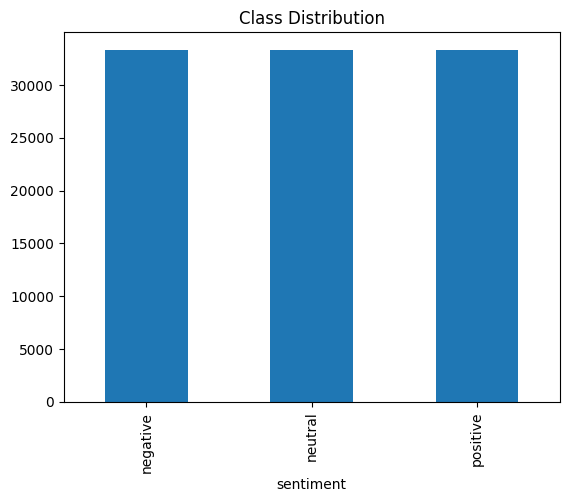

In [18]:
# Display class distribution
print(df['sentiment'].value_counts())
df['sentiment'].value_counts().plot(kind='bar', title='Class Distribution')
plt.show()

In [19]:
# Display column names OF current dataframe
df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'sentiment',
       'Cleaned_Text'],
      dtype='object')

In [20]:
# Display data types of each column in the dataframe
df.dtypes

Id                         int64
ProductId                 object
UserId                    object
ProfileName               object
HelpfulnessNumerator       int64
HelpfulnessDenominator     int64
Score                      int64
Time                       int64
Summary                   object
sentiment                 object
Cleaned_Text              object
dtype: object

In [21]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(
    max_features=12000,           
    ngram_range=(1, 2),           
    stop_words='english',
    sublinear_tf=True,
    min_df=3,               
    max_df=0.9,            
    analyzer='word'                    
)

X = tfidf.fit_transform(df['Cleaned_Text'])
y = df['sentiment']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Linear SVC Performance
Training Accuracy: 0.8140
Testing Accuracy:  0.7290

Classification Report (Test Set):
              precision    recall  f1-score   support

    negative       0.74      0.75      0.74      6675
     neutral       0.67      0.64      0.65      6722
    positive       0.77      0.80      0.79      6603

    accuracy                           0.73     20000
   macro avg       0.73      0.73      0.73     20000
weighted avg       0.73      0.73      0.73     20000



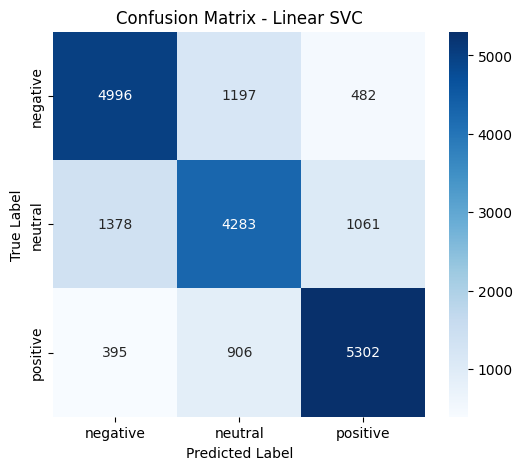


Random Forest Performance
Training Accuracy: 0.7194
Testing Accuracy:  0.6658

Classification Report (Test Set):
              precision    recall  f1-score   support

    negative       0.69      0.68      0.69      6675
     neutral       0.65      0.55      0.60      6722
    positive       0.66      0.76      0.71      6603

    accuracy                           0.67     20000
   macro avg       0.67      0.67      0.66     20000
weighted avg       0.67      0.67      0.66     20000



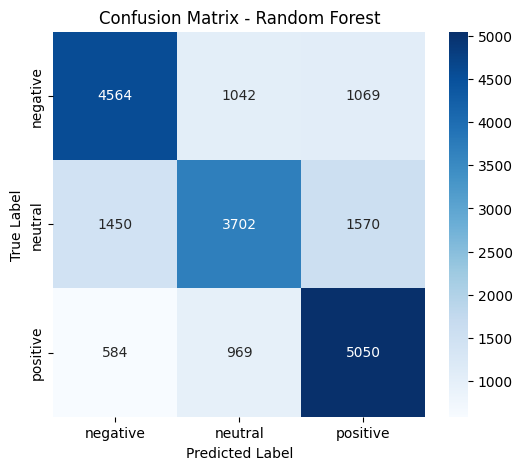


ComplementNB Performance
Training Accuracy: 0.7142
Testing Accuracy:  0.6845

Classification Report (Test Set):
              precision    recall  f1-score   support

    negative       0.69      0.72      0.71      6675
     neutral       0.66      0.50      0.57      6722
    positive       0.69      0.83      0.75      6603

    accuracy                           0.68     20000
   macro avg       0.68      0.69      0.68     20000
weighted avg       0.68      0.68      0.68     20000



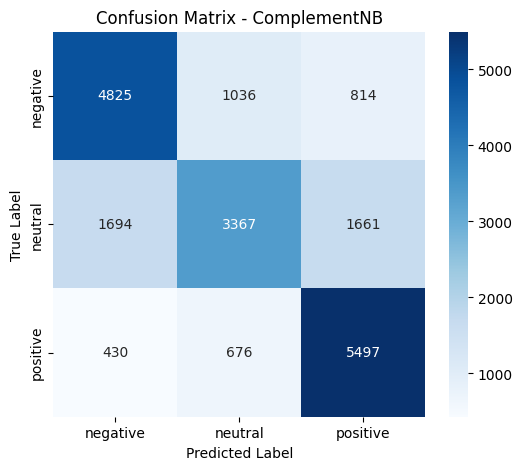


Model Comparison:
Linear SVC      Test Accuracy: 0.7290
ComplementNB    Test Accuracy: 0.6845
Random Forest   Test Accuracy: 0.6658


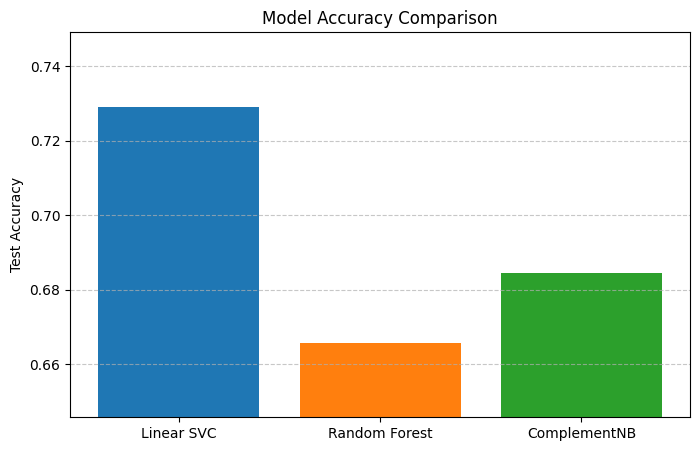

In [22]:
# Helper function to evaluate and visualize model performance
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    # Training evaluation
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    
    # Testing evaluation
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    # Print results
    print(f"\n{'='*50}")
    print(f"{model_name} Performance")
    print(f"{'='*50}")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Testing Accuracy:  {test_accuracy:.4f}")
    
    print("\nClassification Report (Test Set):")
    print(classification_report(y_test, y_test_pred))
    
    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    cm = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=model.classes_, 
                yticklabels=model.classes_)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return test_accuracy

# Initialize models
models = {
    "Linear SVC": LinearSVC(
        class_weight='balanced',
        C=0.4,             
        max_iter=10000,
        random_state=42,
        dual=False             
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=150,
        max_depth=25,           
        min_samples_split=10,     
        min_samples_leaf=4,
        class_weight='balanced_subsample',
        random_state=42,
        n_jobs=-1,
        max_features='sqrt'             
    ),
    "ComplementNB": ComplementNB( 
        alpha=0.75,
        norm=True,
        force_alpha=True
    )
}

# Dictionary to store test accuracies
results = {}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    test_acc = evaluate_model(model, X_train, y_train, X_test, y_test, name)
    results[name] = test_acc

# Compare model performance
print("\nModel Comparison:")
for name, acc in sorted(results.items(), key=lambda x: x[1], reverse=True):
    print(f"{name:15} Test Accuracy: {acc:.4f}")

# Plot accuracy comparison
plt.figure(figsize=(8, 5))
plt.bar(results.keys(), results.values(), color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Test Accuracy')
plt.ylim(min(results.values()) - 0.02, max(results.values()) + 0.02)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [23]:
# Save the best model and vectorizer

joblib.dump(tfidf, 'tfidf_vectorizer.pkl')
joblib.dump(models['Linear SVC'], 'best_model.pkl')

['best_model.pkl']